# Ads - exploratory data analysis (EDA)

NYT , advertising data in 2012, for 1 month (seperated by daily files)

### The Unseen


**ads_behavior**
- [x] Imp.>10, can be a segment as _Engaged_After_Over_Exposed_ **(approx. 2K+)**
- [x] Imp.>10 & Clicks=0, can be a segment as _Ads_Inertia_ **(approx. 12K+)**
- [x] Imp.>0 & Clicks=0 as _Unengaged_ **(400K+)**
- [x] Clicks>0 as _Engaged_ **(37K+)**


**type**
- [x] Age=0, Anonymous **(30%)** vs Signed **(70%)**



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()


In [2]:
# nyt ads' clicks, and some kind of funnel
# gender: 0=female
# signed_in: 0=false, 1=true

raw_data = pd.read_csv('dataset/nyt_ads_clicks_2012/nyt1.csv')

raw_data['isClicked'] = raw_data['Clicks'].map({1:True, 0:False, 2:True, 3:True, 4:True})   
raw_data['isSigned'] = raw_data['Signed_In'].map({1:True, 0:False})  # misleading our understanding


raw_data.head()

,Age,Gender,Impressions,Clicks,Signed_In,isClicked,isSigned
0,36,0,3,0,1,False,True
1,73,1,3,0,1,False,True
2,30,0,3,0,1,False,True
3,49,1,3,0,1,False,True
4,47,1,11,0,1,False,True


## Understanding What we got


- no missing values in data. it was already cleaned data, so it is also _misleading_
- age contains 0 values. median 31, close to mean (29.5).
- gender **%36 male**. 
- impressions, mean (5) = median (5). Has outliers (positive skewed) - %75 is 6 but max 20. 
    - **an average user sees 5 times Ads**
- signed_in is boolean (infact) !  true is most common (that means users are forced to signed in or not new users.  
    - so i generated isSigned
- clicks is number but mostly 1 times! it may skew some calculations, so >1 clicks may be mapped to 1 (isSigned)
    - so we can generate another feature. isClicked, false is most common. **%8.6 Ads-Click-Rate**
    - is Ads, same or not. i do not know
    
- if a user signed_in, we have Age and Gender info. So that data comes from CRM not Google Analtics! 
    - **%70 signed_in**, **%30 anonymous**
- **%0.6 never saw an Ads**



In [3]:
raw_data.describe(include='all')


,Age,Gender,Impressions,Clicks,Signed_In,isClicked,isSigned
count,458441.000000,458441.000000,458441.000000,458441.000000,458441.000000,458441,458441
unique,NaN,NaN,NaN,NaN,NaN,2,2
top,NaN,NaN,NaN,NaN,NaN,False,True
freq,NaN,NaN,NaN,NaN,NaN,418603,321335
mean,29.482551,0.367037,5.007316,0.092594,0.700930,NaN,NaN
std,23.607034,0.481997,2.239349,0.309973,0.457851,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.000000,0.000000,3.000000,0.000000,0.000000,NaN,NaN
50%,31.000000,0.000000,5.000000,0.000000,1.000000,NaN,NaN
75%,48.000000,1.000000,6.000000,0.000000,1.000000,NaN,NaN


## enrichment - calculated columns

#### Create a new variable, 
    - age_group to categorize “<18", "18-24", "25-34", "35-44", "45-54", "55-64", and "65+"
    - CTR = clicks / impressions

In [4]:
data = raw_data

data.loc[data.Age == 0, 'Age_Group'] = 'Anonymous'  # we discovered only sign_in users has gender and age
data.loc[(data.Age < 18) & (data.Age > 0), 'Age_Group'] = '<18'
data.loc[(data.Age >= 18) & (data.Age <= 24), 'Age_Group'] = '18-24'
data.loc[(data.Age >= 25) & (data.Age <= 34), 'Age_Group'] = '25-34'
data.loc[(data.Age >= 35) & (data.Age <= 44), 'Age_Group'] = '35-44'
data.loc[(data.Age >= 45) & (data.Age <= 64), 'Age_Group'] = '55-64'
data.loc[(data.Age >= 65), 'Age_Group'] = '65+'

data.head()

,Age,Gender,Impressions,Clicks,Signed_In,isClicked,isSigned,Age_Group
0,36,0,3,0,1,False,True,35-44
1,73,1,3,0,1,False,True,65+
2,30,0,3,0,1,False,True,25-34
3,49,1,3,0,1,False,True,55-64
4,47,1,11,0,1,False,True,55-64


In [5]:
data['CTR'] = data.Clicks/data.Impressions #Clicks>1 skews this calculation ?. at least that is very low impact!


data.head(10)

,Age,Gender,Impressions,Clicks,Signed_In,isClicked,isSigned,Age_Group,CTR
0,36,0,3,0,1,False,True,35-44,0.000000
1,73,1,3,0,1,False,True,65+,0.000000
2,30,0,3,0,1,False,True,25-34,0.000000
3,49,1,3,0,1,False,True,55-64,0.000000
4,47,1,11,0,1,False,True,55-64,0.000000
5,47,0,11,1,1,True,True,55-64,0.090909
6,0,0,7,1,0,True,False,Anonymous,0.142857
7,46,0,5,0,1,False,True,55-64,0.000000
8,16,0,3,0,1,False,True,<18,0.000000
9,52,0,4,0,1,False,True,55-64,0.000000


In [6]:
x = data[data.isSigned == True]

x.describe()

# if a user signed_in, we have Age and Gender info

,Age,Gender,Impressions,Clicks,Signed_In,CTR
count,321335.000000,321335.000000,321335.000000,321335.000000,321335.0,319198.000000
mean,42.062054,0.523644,5.010584,0.071480,1.0,0.014254
std,16.308117,0.499441,2.238784,0.268659,0.0,0.060280
min,7.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,29.000000,0.000000,3.000000,0.000000,1.0,0.000000
50%,41.000000,1.000000,5.000000,0.000000,1.0,0.000000
75%,53.000000,1.000000,6.000000,0.000000,1.0,0.000000
max,108.000000,1.000000,20.000000,3.000000,1.0,1.000000


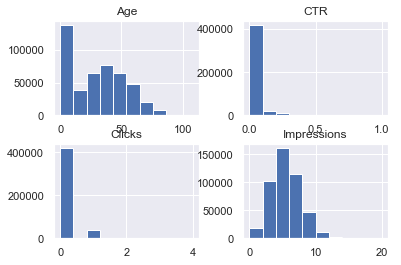

In [7]:
x = data.hist(column=['Age', 'Impressions', 'Clicks', 'CTR'])
# y = data.Impressions.hist()

# 2- possible segments for click_behavior
# Imp.>10 can be a segment as over-exposed


# Imp.>10 & Clicks =0 can be a segment as ads-inertia

In [8]:
impression_limit = data.Impressions.mean() + 2 * data.Impressions.std()


ads_inertia = data[(data.Clicks == 0) & (data.Impressions > 10)]
over_exposed = data[(data.Clicks > 0) & (data.Impressions > 10)]

impression_limit, len(ads_inertia), len(over_exposed)

(9.486013860524853, 5071, 1210)

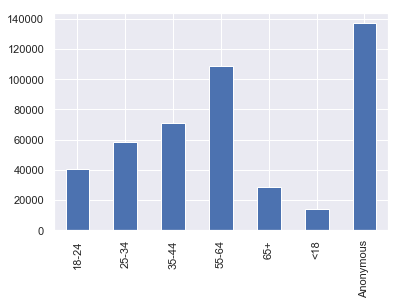

In [9]:
data['Age_Group'].value_counts().sort_index().plot(kind='bar')

### Plot the distributions of number impressions and click-through-rate (CTR=# clicks/# impressions) for these six age categories
 

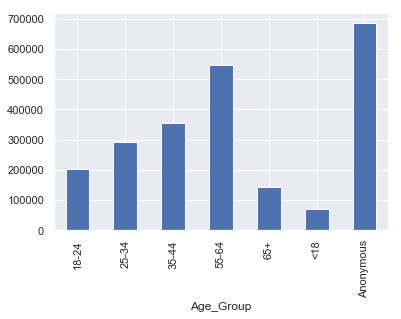

In [10]:
imp_by_age = data.groupby(['Age_Group']).sum()

x = imp_by_age.Impressions.plot(kind='bar')

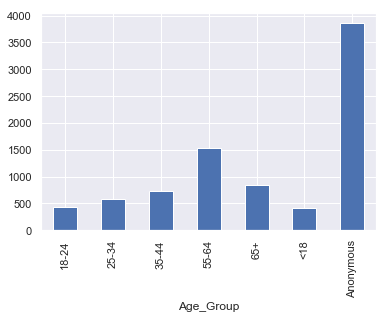

In [11]:
imp_by_age = data.groupby(['Age_Group']).sum()

y = imp_by_age.CTR.plot(kind='bar')


### segment users by ads behavior

In [12]:
# limits

impression_limit = data.Impressions.mean() + 2 * data.Impressions.std()

impression_limit

9.486013860524853

In [13]:
# below records means wrong-data !
# this may be filled in another files. 

data.loc[(data.Impressions == 0) & (data.Clicks >  0), 'delete'] = 'x'

data.head()

,Age,Gender,Impressions,Clicks,Signed_In,isClicked,isSigned,Age_Group,CTR,delete
0,36,0,3,0,1,False,True,35-44,0.0,NaN
1,73,1,3,0,1,False,True,65+,0.0,NaN
2,30,0,3,0,1,False,True,25-34,0.0,NaN
3,49,1,3,0,1,False,True,55-64,0.0,NaN
4,47,1,11,0,1,False,True,55-64,0.0,NaN


In [14]:

data.loc[data.Impressions == 0, 'Ads_Behavior'] = 'UnExposed.Imp=0'  

data.loc[data.Impressions > 0, 'Ads_Behavior'] = 'Exposed.Imp>0'

data.loc[(data.Impressions > 0) & (data.Clicks == 0), 'Ads_Behavior'] = 'UnEngaged.Imp>0.Clicks=0'

data.loc[data.Clicks > 0, 'Ads_Behavior'] = 'Engaged.Clicks>0'
data.loc[(data.Clicks == 0) & (data.Impressions > impression_limit), 'Ads_Behavior'] = 'Ads_Inertia.Imp>10.Clicks=0'
data.loc[(data.Clicks > 0) & (data.Impressions > impression_limit), 'Ads_Behavior'] = 'Engaged_After_Over_Exposed.Imp>10.Clicks>0'

data.head()

,Age,Gender,Impressions,Clicks,Signed_In,isClicked,isSigned,Age_Group,CTR,delete,Ads_Behavior
0,36,0,3,0,1,False,True,35-44,0.0,NaN,UnEngaged.Imp>0.Clicks=0
1,73,1,3,0,1,False,True,65+,0.0,NaN,UnEngaged.Imp>0.Clicks=0
2,30,0,3,0,1,False,True,25-34,0.0,NaN,UnEngaged.Imp>0.Clicks=0
3,49,1,3,0,1,False,True,55-64,0.0,NaN,UnEngaged.Imp>0.Clicks=0
4,47,1,11,0,1,False,True,55-64,0.0,NaN,Ads_Inertia.Imp>10.Clicks=0


In [15]:
data.groupby('Ads_Behavior').size()


Ads_Behavior
Ads_Inertia.Imp>10.Clicks=0                    12061
Engaged.Clicks>0                               37261
Engaged_After_Over_Exposed.Imp>10.Clicks>0      2577
UnEngaged.Imp>0.Clicks=0                      403476
UnExposed.Imp=0                                 3066
dtype: int64

## explore data

using new segments/categories, explore visually